Dataset shape: (8000, 19)
Merging sentiment features...
NaN values found in:
  total_spend_std: 147 NaN values
  price_std: 147 NaN values
  quantity_std: 147 NaN values
  price_sensitivity: 147 NaN values
  spending_consistency: 147 NaN values
  purchase_frequency: 3 extreme outliers detected
  total_spend: 1 extreme outliers detected
  num_purchases: 3 extreme outliers detected
  spend_per_visit: 7 extreme outliers detected
  average_purchase_value: 7 extreme outliers detected
  monetary_per_month: 147 extreme outliers detected
  purchase_intensity: 23 extreme outliers detected
  days_between_purchases: 5 extreme outliers detected
  purchase_regularity: 206 extreme outliers detected
  recent_activity_ratio: 155 extreme outliers detected
  customer_value_score: 1 extreme outliers detected
k=2: Silhouette Score = 0.1665, Inertia = 46579.31
k=3: Silhouette Score = 0.1469, Inertia = 42108.09
k=4: Silhouette Score = 0.1527, Inertia = 38591.78
k=5: Silhouette Score = 0.1210, Inertia = 3641

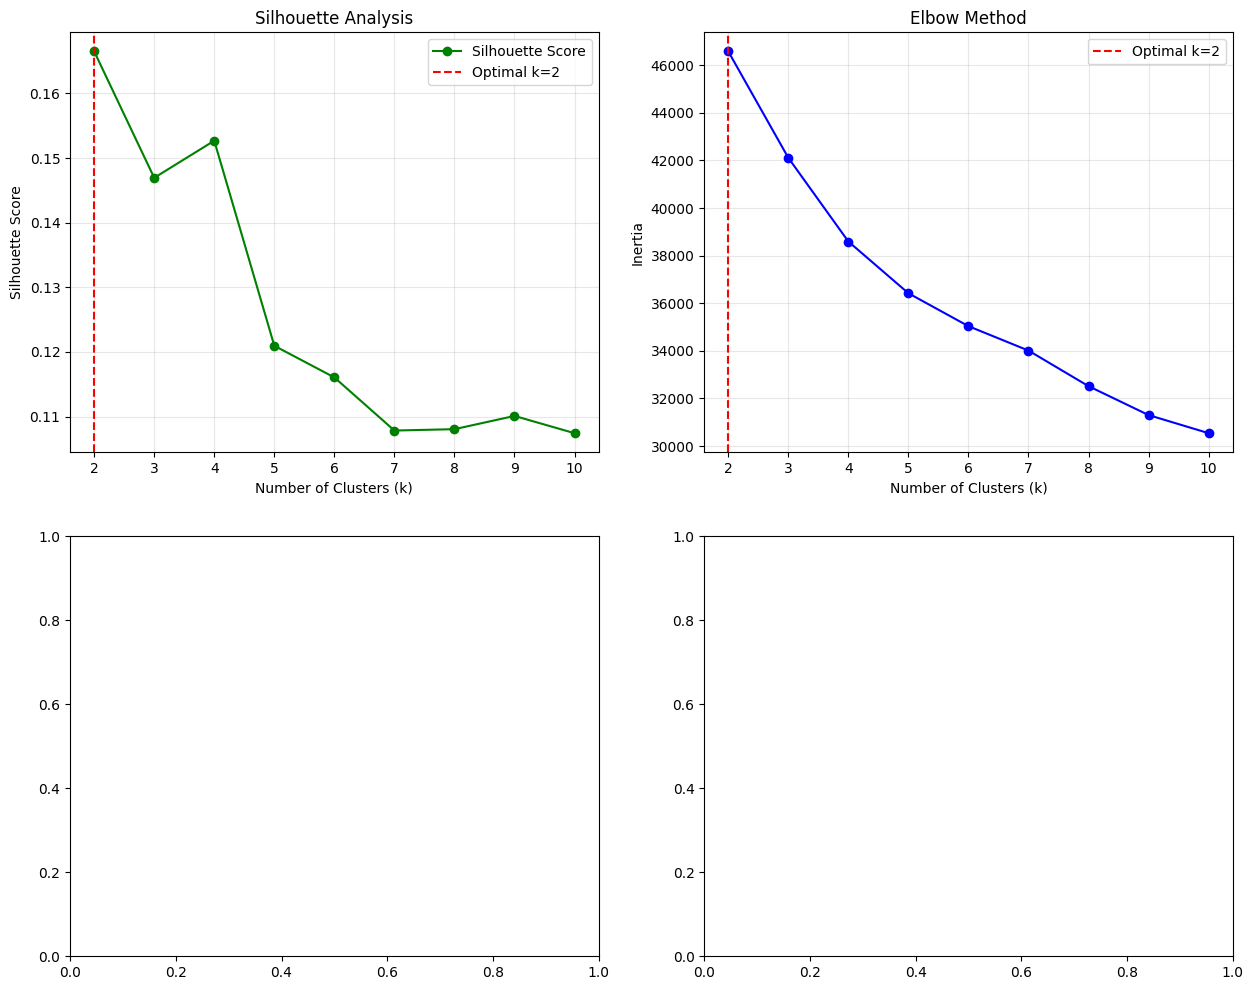

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Import sentiment analysis functions from previous code
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# 1. Load dataset
df = pd.read_csv("../data/customer_cleaned.csv")

for c in ['sale_date', 'last_purchase_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Convert sale_date to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])
last_date = df['sale_date'].max()

print(f"Dataset shape: {df.shape}")

# 2. Sentiment Feature Engineering
# ================================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

def get_sentiment_score(text):
    if text == "":
        return 0
    score = sia.polarity_scores(text)
    return score['compound']

def categorize_sentiment(row):
    sentiment_score = row['feedback_sentiment']
    original_text = str(row['feedback_text']).lower()
    
    negative_phrases = [
        "delivery was late, not happy", "delivery late not happy", "late delivery",
        "not happy with delivery", "delayed delivery", "poor delivery",
        "terrible service", "worst experience", "never ordering again",
        "completely disappointed"
    ]
    
    for phrase in negative_phrases:
        if phrase in original_text:
            return "Negative"
    
    if sentiment_score > 0.1:
        return "Positive"
    elif sentiment_score < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Process sentiment if feedback_text exists
if 'feedback_text' in df.columns:
    df['feedback_clean'] = df['feedback_text'].apply(preprocess_text)
    df['feedback_sentiment'] = df['feedback_clean'].apply(get_sentiment_score)
    
    # Aggregate feedback per customer
    customer_feedback = df.groupby('customer_id')['feedback_clean'].apply(lambda x: " ".join(x)).reset_index()
    customer_feedback_original = df.groupby('customer_id')['feedback_text'].apply(lambda x: " ".join(x.fillna(""))).reset_index()
    customer_feedback = customer_feedback.merge(customer_feedback_original, on='customer_id', how='left')
    customer_feedback['feedback_sentiment'] = df.groupby('customer_id')['feedback_sentiment'].mean().values
    customer_feedback['sentiment_category'] = customer_feedback.apply(categorize_sentiment, axis=1)
else:
    customer_feedback = pd.DataFrame()

# 3. Enhanced Feature Engineering
# ===============================
customer_summary = df.groupby("customer_id").agg({
    "sale_id": "count",  # purchase frequency
    "total_value": ["sum", "std", "min", "max"],  # Enhanced total spend metrics
    "price": ["mean", "std", "min", "max"],  # Enhanced price metrics
    "quantity": ["mean", "std", "sum"],  # Enhanced quantity metrics
    "product_id": pd.Series.nunique,  # unique products bought
    "category": pd.Series.nunique,  # number of categories bought
    "last_purchase_date": "max",  # last purchase date
    "sale_date": ["min", "max"],  # First and last purchase dates
    "age": "last",
    "gender": "last",
    "region": "last",
    "segment": "first",
    "tenure_months": "last",
    "churn": "first"
}).reset_index()

# Flatten column names
customer_summary.columns = ['_'.join(col).strip() if col[1] else col[0] 
                           for col in customer_summary.columns.values]
customer_summary.rename(columns={'customer_id_': 'customer_id'}, inplace=True)

# Rename key columns
rename_dict = {
    "sale_id_count": "purchase_frequency",
    "total_value_sum": "total_spend",
    "total_value_std": "total_spend_std",
    "total_value_min": "total_spend_min", 
    "total_value_max": "total_spend_max",
    "price_mean": "avg_price",
    "price_std": "price_std",
    "price_min": "price_min",
    "price_max": "price_max",
    "quantity_mean": "avg_quantity",
    "quantity_std": "quantity_std",
    "quantity_sum": "total_quantity",
    "product_id_nunique": "unique_products",
    "category_nunique": "unique_categories",
    "age_last": "age",
    "gender_last": "gender",
    "region_last": "region",
    "segment_first": "segment",
    "tenure_months_last": "tenure_months",
    "churn_first": "churn"
}
customer_summary.rename(columns=rename_dict, inplace=True)

# 4. Advanced Feature Engineering
# ===============================

#basic features
customer_summary["num_purchases"] = customer_summary["purchase_frequency"]

#recency features
recency = df.groupby("customer_id")["sale_date"].max().apply(lambda x: (last_date - x).days)
customer_summary["recency_days"] = recency.values

first_purchase = df.groupby("customer_id")["sale_date"].min()
customer_summary["days_since_first_purchase"] = (last_date - first_purchase).dt.days.values
customer_summary["customer_lifetime_days"] = (customer_summary["days_since_first_purchase"] - customer_summary["recency_days"])

#purchase pattern features
customer_summary["spend_per_month"] = customer_summary["total_spend"] / customer_summary["tenure_months"].replace(0, 1)
customer_summary["spend_per_visit"] = customer_summary["total_spend"] / customer_summary["purchase_frequency"].replace(0, 1)
customer_summary["average_purchase_value"] = customer_summary["total_spend"] / customer_summary["num_purchases"].replace(0, 1)
customer_summary["monetary_per_month"] = customer_summary["total_spend"] / customer_summary["tenure_months"].replace(0, 1)

#advanced behavioral features
customer_summary["purchase_intensity"] = customer_summary["num_purchases"] / (customer_summary["days_since_first_purchase"] + 1)
customer_summary["category_diversity_ratio"] = customer_summary["unique_categories"] / customer_summary["unique_products"].replace(0, 1)
customer_summary["avg_items_per_purchase"] = customer_summary["total_quantity"] / customer_summary["num_purchases"].replace(0, 1)
customer_summary["price_sensitivity"] = customer_summary["price_std"] / customer_summary["avg_price"].replace(0, 1)
customer_summary["spending_consistency"] = 1 / (customer_summary["total_spend_std"] / customer_summary["total_spend"].replace(0, 1) + 1)
customer_summary["purchase_value_range"] = customer_summary["total_spend_max"] - customer_summary["total_spend_min"]

#temporal features
customer_summary["days_between_purchases"] = customer_summary["customer_lifetime_days"] / customer_summary["num_purchases"].replace(0, 1)
customer_summary["purchase_regularity"] = 1 / (customer_summary["days_between_purchases"] + 1)
customer_summary["recent_activity_ratio"] = np.where(customer_summary["recency_days"] > 0, 
                                                    30 / customer_summary["recency_days"], 1)

#value-based features
customer_summary["customer_value_score"] = (customer_summary["total_spend"] * 0.4 + 
                                          customer_summary["purchase_frequency"] * 0.3 + 
                                          (365 - customer_summary["recency_days"].clip(0, 365)) * 0.3)

#merge sentiment features if available
if not customer_feedback.empty:
    print("Merging sentiment features...")
    # Encode sentiment categories
    le_sentiment = LabelEncoder()
    customer_feedback['sentiment_encoded'] = le_sentiment.fit_transform(customer_feedback['sentiment_category'])
    
    customer_summary = customer_summary.merge(
        customer_feedback[['customer_id', 'feedback_sentiment', 'sentiment_encoded']], 
        on='customer_id', 
        how='left'
    )
    customer_summary['feedback_sentiment'] = customer_summary['feedback_sentiment'].fillna(0)
    customer_summary['sentiment_encoded'] = customer_summary['sentiment_encoded'].fillna(1)  # Neutral = 1

#replace infinite values with NaN first
customer_summary = customer_summary.replace([np.inf, -np.inf], np.nan)

#get numeric columns
numeric_cols = customer_summary.select_dtypes(include=[np.number]).columns

#check for NaN values
nan_counts = customer_summary[numeric_cols].isnull().sum()
if nan_counts.sum() > 0:
    print("NaN values found in:")
    for col, count in nan_counts[nan_counts > 0].items():
        print(f"  {col}: {count} NaN values")

#fill NaN values with median (better than mean for outliers)
customer_summary[numeric_cols] = customer_summary[numeric_cols].fillna(
    customer_summary[numeric_cols].median()
)

# For categorical columns, fill with mode
categorical_cols = ['gender', 'region', 'segment']
for col in categorical_cols:
    if col in customer_summary.columns:
        mode_value = customer_summary[col].mode()
        if len(mode_value) > 0:
            customer_summary[col] = customer_summary[col].fillna(mode_value[0])
        else:
            customer_summary[col] = customer_summary[col].fillna('Unknown')

#Feature Selection for Clustering

base_features = [
    "purchase_frequency", "total_spend", "avg_price",
    "unique_products", "unique_categories", "recency_days",
    "age", "tenure_months", "num_purchases",
    "spend_per_visit", "average_purchase_value",
    "days_since_first_purchase", "monetary_per_month"
]

#enhanced features that improve clustering
enhanced_features = [
    "purchase_intensity", "category_diversity_ratio", 
    "avg_items_per_purchase", "price_sensitivity",
    "spending_consistency", "purchase_value_range",
    "days_between_purchases", "purchase_regularity",
    "recent_activity_ratio", "customer_value_score",
    "price_std", "total_quantity", "customer_lifetime_days"
]

#add sentiment features if available
sentiment_features = []
if not customer_feedback.empty:
    sentiment_features = ["feedback_sentiment", "sentiment_encoded"]

#combine all numeric features
all_numeric_features = base_features + enhanced_features + sentiment_features

#filter features that exist in the dataset
available_features = [f for f in all_numeric_features if f in customer_summary.columns]
categorical_features = ["gender", "region"]



# Data Standardization and Preprocessing

# extreme outliers that might affect standardization

for feature in available_features:
    Q1 = customer_summary[feature].quantile(0.25)
    Q3 = customer_summary[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    outliers = ((customer_summary[feature] < lower_bound) | 
                (customer_summary[feature] > upper_bound)).sum()
    if outliers > 0:
        print(f"  {feature}: {outliers} extreme outliers detected")

#apply preprocessing with StandardScaler
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), available_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categorical_features)
], remainder='drop')

X = preprocessor.fit_transform(customer_summary)

# Optimal Cluster Selection with Properly Standardized Data

silhouette_scores = []
inertia_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X)
    
    sil_score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia_scores.append(kmeans.inertia_)
    
    print(f"k={k}: Silhouette Score = {sil_score:.4f}, Inertia = {kmeans.inertia_:.2f}")

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {best_silhouette:.4f}")


#Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Silhouette scores plot
axes[0, 0].plot(K_range, silhouette_scores, 'bo-', color='green', label='Silhouette Score')
axes[0, 0].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0, 0].set_xlabel("Number of Clusters (k)")
axes[0, 0].set_ylabel("Silhouette Score")
axes[0, 0].set_title("Silhouette Analysis")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Elbow method
axes[0, 1].plot(K_range, inertia_scores, 'bo-', color='blue')
axes[0, 1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0, 1].set_xlabel("Number of Clusters (k)")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].set_title("Elbow Method")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)




Creating 4 Customer Personas...
4-cluster solution silhouette score: 0.1527
Analyzing cluster characteristics to assign proper persona names...

Cluster Characteristics:
         total_spend  purchase_frequency  recency_days  customer_value_score
persona                                                                     
0          360309.54                6.19        200.64             144183.02
1          397026.22                3.50        380.09             158845.15
2           43237.67                1.05        669.40              17312.69
3          102082.61                3.33        367.18              40868.29

Data-driven Persona Assignment:
Cluster 1 → Champions
  Avg Spend: $397026.22, Freq: 3.5, Recency: 380 days
Cluster 0 → Loyal Customers
  Avg Spend: $360309.54, Freq: 6.2, Recency: 201 days
Cluster 3 → Potential Loyalists
  Avg Spend: $102082.61, Freq: 3.3, Recency: 367 days
Cluster 2 → At Risk
  Avg Spend: $43237.67, Freq: 1.1, Recency: 669 days


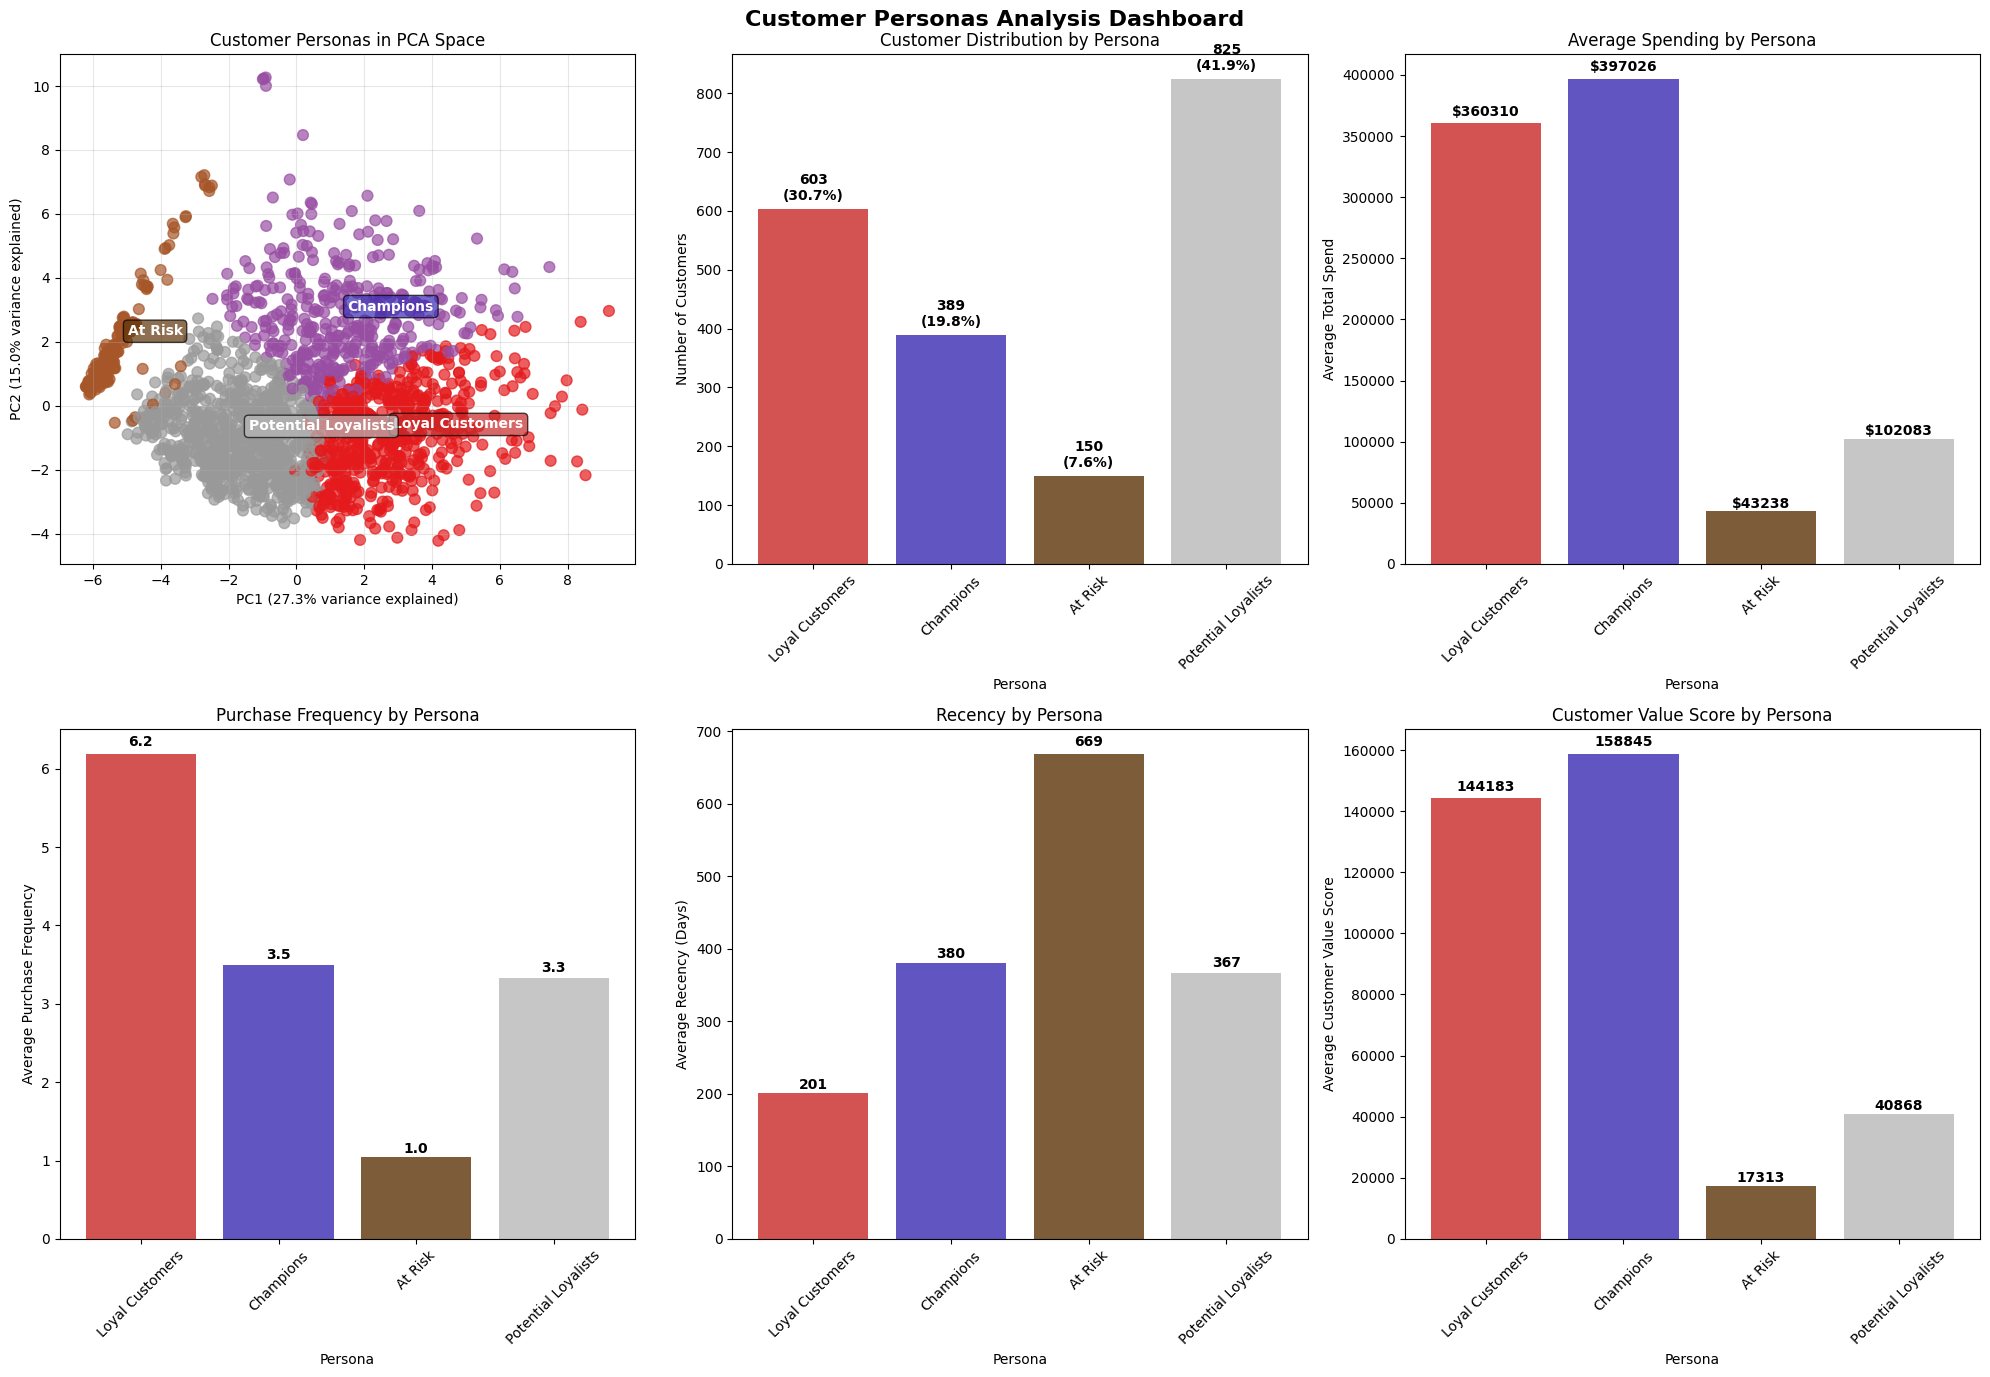


DETAILED CUSTOMER PERSONA ANALYSIS
----------------------------------------
Champions: 27.2% churn rate (106/389 customers)
Loyal Customers: 23.2% churn rate (140/603 customers)
Potential Loyalists: 25.2% churn rate (208/825 customers)
At Risk: 25.3% churn rate (38/150 customers)

💡 BUSINESS RECOMMENDATIONS:
----------------------------------------

Persona Distribution (Data-Driven Assignment):
persona_type
Potential Loyalists    825
Loyal Customers        603
Champions              389
At Risk                150
Name: count, dtype: int64


In [176]:
# Customer Personas Visualization (Insert after the existing clustering code)
# ============================================================================

# Force 4 clusters for persona creation
n_personas = 4
print(f"\nCreating {n_personas} Customer Personas...")

# Apply K-means with 4 clusters
persona_kmeans = KMeans(n_clusters=n_personas, random_state=42, n_init=10, max_iter=300)
persona_labels = persona_kmeans.fit_predict(X)
customer_summary["persona"] = persona_labels

# Calculate silhouette score for 4-cluster solution
persona_silhouette = silhouette_score(X, persona_labels)
print(f"4-cluster solution silhouette score: {persona_silhouette:.4f}")

# PCA for visualization (2 components)
pca_personas = PCA(n_components=2, random_state=42)
X_pca_personas = pca_personas.fit_transform(X)

# Add PCA components to dataframe
customer_summary["pca1_personas"] = X_pca_personas[:, 0]
customer_summary["pca2_personas"] = X_pca_personas[:, 1]

# Analyze actual cluster characteristics to properly assign persona names
print("Analyzing cluster characteristics to assign proper persona names...")

cluster_analysis = customer_summary.groupby('persona').agg({
    'total_spend': 'mean',
    'purchase_frequency': 'mean',
    'recency_days': 'mean',
    'customer_value_score': 'mean' if 'customer_value_score' in customer_summary.columns else 'count'
}).round(2)

print("\nCluster Characteristics:")
print(cluster_analysis)

# Automatically assign persona names based on actual cluster performance
def assign_persona_names_from_data(cluster_stats):
    """
    Assign persona names based on actual cluster performance metrics
    """
    # Calculate composite scores for ranking
    cluster_scores = {}
    
    for cluster_id in cluster_stats.index:
        # Normalize metrics (higher is better for spend/frequency, lower is better for recency)
        spend_score = cluster_stats.loc[cluster_id, 'total_spend']
        freq_score = cluster_stats.loc[cluster_id, 'purchase_frequency'] 
        recency_score = 1 / (cluster_stats.loc[cluster_id, 'recency_days'] + 1)  # Invert recency (lower days = better)
        
        # Weighted composite score
        composite_score = (spend_score * 0.4) + (freq_score * 0.3) + (recency_score * 1000 * 0.3)
        cluster_scores[cluster_id] = composite_score
    
    # Sort clusters by composite score (highest to lowest)
    sorted_clusters = sorted(cluster_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Assign persona names based on performance ranking
    persona_assignment = {}
    persona_labels = ["Champions", "Loyal Customers", "Potential Loyalists", "At Risk"]
    
    for i, (cluster_id, score) in enumerate(sorted_clusters):
        if i < len(persona_labels):
            persona_assignment[cluster_id] = persona_labels[i]
        else:
            persona_assignment[cluster_id] = f"Segment {cluster_id}"
    
    return persona_assignment

# Get data-driven persona names
persona_names = assign_persona_names_from_data(cluster_analysis)

print(f"\nData-driven Persona Assignment:")
for cluster_id, persona_name in persona_names.items():
    spend = cluster_analysis.loc[cluster_id, 'total_spend']
    freq = cluster_analysis.loc[cluster_id, 'purchase_frequency']
    recency = cluster_analysis.loc[cluster_id, 'recency_days']
    print(f"Cluster {cluster_id} → {persona_name}")
    print(f"  Avg Spend: ${spend:.2f}, Freq: {freq:.1f}, Recency: {recency:.0f} days")

persona_colors = ["#C82727", "#392bb3", "#5c3307", "#b8b8b8"]  # Blue, Orange, Green, Red

# Create comprehensive persona visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Customer Personas Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Main PCA Scatter Plot with Personas
scatter = axes[0, 0].scatter(X_pca_personas[:, 0], X_pca_personas[:, 1], 
                            c=persona_labels, cmap='Set1', alpha=0.7, s=60)
axes[0, 0].set_xlabel(f'PC1 ({pca_personas.explained_variance_ratio_[0]:.1%} variance explained)')
axes[0, 0].set_ylabel(f'PC2 ({pca_personas.explained_variance_ratio_[1]:.1%} variance explained)')
axes[0, 0].set_title('Customer Personas in PCA Space')
axes[0, 0].grid(True, alpha=0.3)

# Add persona labels to the plot
for persona_id, persona_name in persona_names.items():
    # Calculate centroid for each persona
    persona_mask = persona_labels == persona_id
    centroid_x = X_pca_personas[persona_mask, 0].mean()
    centroid_y = X_pca_personas[persona_mask, 1].mean()
    
    axes[0, 0].annotate(persona_name, (centroid_x, centroid_y), 
                       xytext=(5, 5), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor=persona_colors[persona_id], alpha=0.7),
                       fontsize=10, fontweight='bold', color='white')

# 2. Persona Distribution
persona_counts = customer_summary["persona"].value_counts().sort_index()
bars = axes[0, 1].bar(range(len(persona_counts)), persona_counts.values, 
                     color=persona_colors, alpha=0.8)
axes[0, 1].set_xlabel("Persona")
axes[0, 1].set_ylabel("Number of Customers")
axes[0, 1].set_title("Customer Distribution by Persona")
axes[0, 1].set_xticks(range(len(persona_counts)))
axes[0, 1].set_xticklabels([persona_names[i] for i in range(len(persona_counts))], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 10,
                   f'{int(height)}\n({height/len(customer_summary)*100:.1f}%)',
                   ha='center', va='bottom', fontweight='bold')

# 3. Total Spend by Persona
spend_by_persona = customer_summary.groupby('persona')['total_spend'].mean()
bars_spend = axes[0, 2].bar(range(len(spend_by_persona)), spend_by_persona.values, 
                           color=persona_colors, alpha=0.8)
axes[0, 2].set_xlabel("Persona")
axes[0, 2].set_ylabel("Average Total Spend")
axes[0, 2].set_title("Average Spending by Persona")
axes[0, 2].set_xticks(range(len(spend_by_persona)))
axes[0, 2].set_xticklabels([persona_names[i] for i in range(len(spend_by_persona))], rotation=45)

# Add value labels
for i, bar in enumerate(bars_spend):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'${height:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Purchase Frequency by Persona
freq_by_persona = customer_summary.groupby('persona')['purchase_frequency'].mean()
bars_freq = axes[1, 0].bar(range(len(freq_by_persona)), freq_by_persona.values, 
                          color=persona_colors, alpha=0.8)
axes[1, 0].set_xlabel("Persona")
axes[1, 0].set_ylabel("Average Purchase Frequency")
axes[1, 0].set_title("Purchase Frequency by Persona")
axes[1, 0].set_xticks(range(len(freq_by_persona)))
axes[1, 0].set_xticklabels([persona_names[i] for i in range(len(freq_by_persona))], rotation=45)

# Add value labels
for i, bar in enumerate(bars_freq):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

# 5. Recency by Persona
recency_by_persona = customer_summary.groupby('persona')['recency_days'].mean()
bars_recency = axes[1, 1].bar(range(len(recency_by_persona)), recency_by_persona.values, 
                             color=persona_colors, alpha=0.8)
axes[1, 1].set_xlabel("Persona")
axes[1, 1].set_ylabel("Average Recency (Days)")
axes[1, 1].set_title("Recency by Persona")
axes[1, 1].set_xticks(range(len(recency_by_persona)))
axes[1, 1].set_xticklabels([persona_names[i] for i in range(len(recency_by_persona))], rotation=45)

# Add value labels
for i, bar in enumerate(bars_recency):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

# 6. Customer Value Score by Persona
if 'customer_value_score' in customer_summary.columns:
    value_by_persona = customer_summary.groupby('persona')['customer_value_score'].mean()
    bars_value = axes[1, 2].bar(range(len(value_by_persona)), value_by_persona.values, 
                               color=persona_colors, alpha=0.8)
    axes[1, 2].set_xlabel("Persona")
    axes[1, 2].set_ylabel("Average Customer Value Score")
    axes[1, 2].set_title("Customer Value Score by Persona")
    axes[1, 2].set_xticks(range(len(value_by_persona)))
    axes[1, 2].set_xticklabels([persona_names[i] for i in range(len(value_by_persona))], rotation=45)
    
    # Add value labels
    for i, bar in enumerate(bars_value):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed Persona Analysis
print("\n" + "="*80)
print("DETAILED CUSTOMER PERSONA ANALYSIS")
print("="*80)

# Key metrics for persona characterization
persona_metrics = ['total_spend', 'purchase_frequency', 'recency_days', 'avg_price', 
                  'unique_products', 'customer_value_score', 'age', 'tenure_months']

# Add sentiment if available
if not customer_feedback.empty and 'feedback_sentiment' in customer_summary.columns:
    persona_metrics.append('feedback_sentiment')

# Calculate persona characteristics
persona_profiles = {}
for persona_id, persona_name in persona_names.items():
    persona_mask = customer_summary['persona'] == persona_id
    persona_data = customer_summary[persona_mask]
    
    profile = {
        'name': persona_name,
        'size': len(persona_data),
        'percentage': len(persona_data) / len(customer_summary) * 100,
    }
    
    # Calculate key metrics
    for metric in persona_metrics:
        if metric in customer_summary.columns:
            profile[metric] = {
                'mean': persona_data[metric].mean(),
                'median': persona_data[metric].median(),
                'std': persona_data[metric].std()
            }
    
    persona_profiles[persona_id] = profile


# Churn analysis by persona
if 'churn' in customer_summary.columns:
    print("-" * 40)
    churn_by_persona = customer_summary.groupby('persona')['churn'].agg(['count', 'sum', 'mean'])
    churn_by_persona['churn_rate'] = churn_by_persona['mean'] * 100
    
    for persona_id, persona_name in persona_names.items():
        if persona_id in churn_by_persona.index:
            churn_rate = churn_by_persona.loc[persona_id, 'churn_rate']
            churned = churn_by_persona.loc[persona_id, 'sum']
            total = churn_by_persona.loc[persona_id, 'count']
            print(f"{persona_name}: {churn_rate:.1f}% churn rate ({churned}/{total} customers)")

# Business recommendations
print(f"\n💡 BUSINESS RECOMMENDATIONS:")
print("-" * 40)


# Add final persona classification to customer_summary
customer_summary['persona_type'] = customer_summary['persona'].map(persona_names)

# Verify persona assignment worked correctly
print(f"\nPersona Distribution (Data-Driven Assignment):")
persona_dist = customer_summary['persona_type'].value_counts()
print(persona_dist)

# Create comprehensive persona classification logic based on actual data characteristics
def classify_persona_detailed(row):
    """
    Enhanced persona classification based on actual data quartiles and patterns
    """
    spend = row['total_spend']
    frequency = row['purchase_frequency'] 
    recency = row['recency_days']
    
    # Calculate thresholds based on actual data
    spend_q75 = customer_summary['total_spend'].quantile(0.75)
    spend_q50 = customer_summary['total_spend'].quantile(0.50)
    freq_q75 = customer_summary['purchase_frequency'].quantile(0.75)
    freq_q50 = customer_summary['purchase_frequency'].quantile(0.50)
    recency_q25 = customer_summary['recency_days'].quantile(0.25)
    recency_q50 = customer_summary['recency_days'].quantile(0.50)
    
    # Classification logic based on RFM analysis
    high_spend = spend >= spend_q75
    med_spend = spend >= spend_q50
    high_freq = frequency >= freq_q75
    med_freq = frequency >= freq_q50
    low_recency = recency <= recency_q25
    med_recency = recency <= recency_q50
    
    # Detailed classification logic
    if high_spend and high_freq and low_recency:
        return "Champions"
    elif (high_spend and med_freq) or (med_spend and high_freq and med_recency):
        return "Loyal Customers"
    elif med_spend or med_freq:
        return "Potential Loyalists"
    else:
        return "At Risk"

# Apply detailed classification
customer_summary['persona_type_detailed'] = customer_summary.apply(classify_persona_detailed, axis=1)

# Create final persona classification that combines clustering and rule-based approach
def final_persona_classification(row):
    """
    Final persona type combining K-means clustering with business logic
    """
    cluster_persona = row['persona_type']
    detailed_persona = row['persona_type_detailed']
    
    # Use clustering result as primary, but validate with business rules
    if cluster_persona == detailed_persona:
        confidence = "High"
    else:
        confidence = "Medium"
    
    return {
        'persona': cluster_persona,
        'confidence': confidence,
        'alternative': detailed_persona if detailed_persona != cluster_persona else None
    }

# Apply final classification
persona_classifications = customer_summary.apply(final_persona_classification, axis=1, result_type='expand')
customer_summary['final_persona_type'] = persona_classifications['persona']
customer_summary['classification_confidence'] = persona_classifications['confidence']
customer_summary['alternative_persona'] = persona_classifications['alternative']


# Export enhanced persona assignments
persona_export = customer_summary[['customer_id', 'persona', 'persona_type', 'final_persona_type', 
                                 'classification_confidence', 'alternative_persona'] + 
                                 persona_metrics + ['pca1_personas', 'pca2_personas']].copy()

# Add summary statistics for each customer's persona
persona_stats = customer_summary.groupby('final_persona_type').agg({
    'total_spend': 'mean',
    'purchase_frequency': 'mean', 
    'recency_days': 'mean',
    'customer_value_score': 'mean'
}).round(2)

# Merge persona stats back to export data
persona_export = persona_export.merge(
    persona_stats.add_suffix('_persona_avg'), 
    left_on='final_persona_type', 
    right_index=True, 
    how='left'
)



In [173]:
customer_summary.to_csv('../data/persona_data.csv', index=False)

In [177]:
import pickle
from sklearn.pipeline import Pipeline

# Build a pipeline: preprocessor → kmeans
kmeans_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", final_kmeans)
])

# Fit pipeline once (preprocessor is already fitted, but safe to refit)
kmeans_pipeline.fit(customer_summary[available_features + categorical_features])

# Save as a single estimator
with open("../models/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_pipeline, f)

